In [1]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, OutputLoader, plot_2d_slice, plot_timeseries
from superfv.initial_conditions import kelvin_helmholtz_2d

In [2]:
N = 2048
T = 0.8
gamma = 1.4

path = "/scratch/gpfs/jp7427/out/kelvin-helmholtz_N=2048/"
overwrite = []

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        GL=True,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        include_corners=True,
        adaptive_dt=False,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        include_corners=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-2,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    if overwrite != "all":
        if name not in overwrite:
            try:
                sim = OutputLoader(path + name)
                sim.load_snapshot("all")
                sims[name] = sim
                continue
            except FileNotFoundError:
                pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=kelvin_helmholtz_2d,
        gamma=gamma,
        nx=N,
        ny=N,
        cupy=True,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True, path=path + name, overwrite=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True, path=path + name, overwrite=True)
        sims[name] = sim
    except Exception as e:
        print(f"Failed: {e}")
        continue

Successfully read simulation output from "/scratch/gpfs/jp7427/out/kelvin-helmholtz_N=2048/MUSCL-Hancock"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/kelvin-helmholtz_N=2048/ZS3"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/kelvin-helmholtz_N=2048/MM3"


In [3]:
idx = sims["MUSCL-Hancock"].variable_index_map
vmin = min(
    np.min(sims["MUSCL-Hancock"].snapshots[-1]["u"][idx("rho")]),
    np.min(sims["ZS3"].snapshots[-1]["u"][idx("rho")]),
    np.min(sims["MM3"].snapshots[-1]["u"][idx("rho")]),
)
vmax = max(
    np.max(sims["MUSCL-Hancock"].snapshots[-1]["u"][idx("rho")]),
    np.max(sims["ZS3"].snapshots[-1]["u"][idx("rho")]),
    np.max(sims["MM3"].snapshots[-1]["u"][idx("rho")]),
)

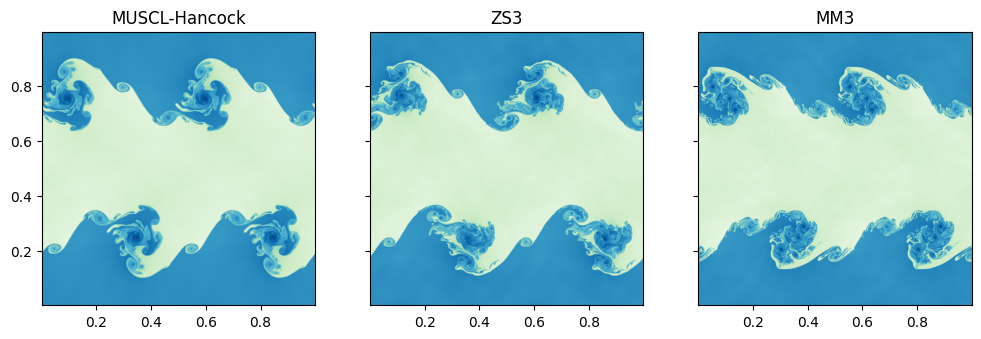

In [4]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

axs[0].set_title("MUSCL-Hancock")
axs[1].set_title("ZS3")
axs[2].set_title("MM3")

im, cbar = plot_2d_slice(
    sims["MUSCL-Hancock"], axs[0], "rho", cmap="GnBu_r", vmin=vmin, vmax=vmax
)
im, cbar = plot_2d_slice(
    sims["ZS3"], axs[1], "rho", cmap="GnBu_r", vmin=vmin, vmax=vmax
)
im, cbar = plot_2d_slice(
    sims["MM3"],
    axs[2],
    "rho",
    cmap="GnBu_r",
    vmin=vmin,
    vmax=vmax,
    overlay_troubles=True,
)

In [5]:
fig.savefig("/home/jp7427/Desktop/superfv/out/kh.png", dpi=1000)

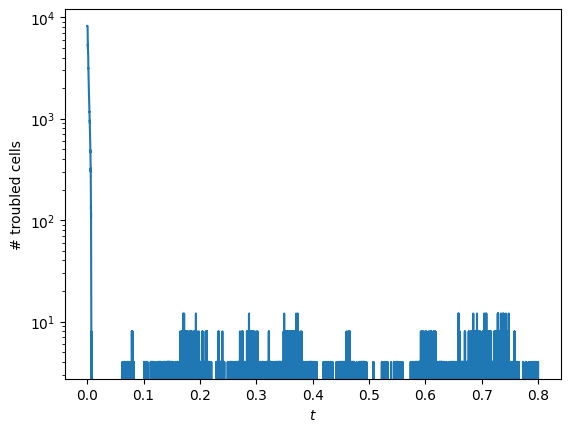

In [6]:
fig, ax = plt.subplots()

ax.set_xlabel(r"$t$")
ax.set_yscale("log")
ax.set_ylabel("# troubled cells")

plot_timeseries(sims["MM3"], ax, "nfine_troubled_cells")